In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
import time
import pandas as pd
import seaborn as sns
from scipy import stats
from typing import List, Tuple, Dict
import warnings
warnings.filterwarnings('ignore')

# Задача о рюкзаке

In [ ]:
class KnapsackProblem:
    """Задача о рюкзаке - классическая комбинаторная задача"""
    def __init__(self, n_items: int, capacity: float, seed: int = None):
        self.n_items = n_items
        self.capacity = capacity
        self.seed = seed if seed is not None else np.random.randint(1000)

        np.random.seed(self.seed)
        # Генерируем случайные веса и стоимости
        self.weights = np.random.uniform(1, 20, n_items)
        self.values = np.random.uniform(10, 100, n_items)
        # Делаем стоимость коррелированной с весом
        self.values = self.values * (1 + 0.3 * self.weights / np.mean(self.weights))

    def evaluate(self, chromosome: np.ndarray) -> float:
        """Оценка решения для задачи о рюкзаке"""
        total_weight = np.dot(chromosome, self.weights)
        total_value = np.dot(chromosome, self.values)

        # Штраф за превышение вместимости
        if total_weight > self.capacity:
            penalty = np.exp(2 * (total_weight - self.capacity) / self.capacity) * 100
            return max(0, total_value - penalty)
        return total_value

# Реализация Genetic Engineering Algorithm

In [ ]:
class GeneticEngineeringAlgorithm:
    """Genetic Engineering Algorithm (GEA)"""

    def __init__(self, problem: KnapsackProblem,population_size: int = 100,max_generations: int = 200,crossover_rate: float = 0.8, mutation_rate: float = 0.02,elite_ratio: float = 0.3,injection_rate: float = 0.4,threshold: float = 0.6):

        self.problem = problem
        self.population_size = population_size
        self.max_generations = max_generations
        self.crossover_rate = crossover_rate
        self.mutation_rate = mutation_rate
        self.elite_ratio = elite_ratio
        self.injection_rate = injection_rate
        self.threshold = threshold
        self.chromosome_length = problem.n_items

        self.population = self._initialize_population()
        self.best_solution = None
        self.best_fitness = 0
        self.fitness_history = []
        self.diversity_history = []

    def _initialize_population(self) -> List[np.ndarray]:
        """Инициализация случайной популяции"""
        return [np.random.randint(0, 2, self.chromosome_length)
                for _ in range(self.population_size)]

    def evaluate_population(self) -> List[float]:
        """Оценка пригодности всей популяции"""
        return [self.problem.evaluate(ind) for ind in self.population]

    def select_parents(self, fitness_values: List[float]) -> Tuple[np.ndarray, np.ndarray]:
        """Турнирная селекция"""
        tournament_size = 3
        parents = []

        for _ in range(2):
            indices = np.random.choice(len(self.population), tournament_size, replace=False)
            tournament_fitness = [fitness_values[i] for i in indices]
            winner_idx = indices[np.argmax(tournament_fitness)]
            parents.append(self.population[winner_idx].copy())

        return parents[0], parents[1]

    def crossover(self, parent1: np.ndarray, parent2: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """Одноточечный кроссовер"""
        if random.random() > self.crossover_rate:
            return parent1.copy(), parent2.copy()

        point = random.randint(1, self.chromosome_length - 1)
        child1 = np.concatenate([parent1[:point], parent2[point:]])
        child2 = np.concatenate([parent2[:point], parent1[point:]])

        return child1, child2

    def mutate(self, chromosome: np.ndarray) -> np.ndarray:
        """Мутация особи"""
        mutated = chromosome.copy()
        for i in range(self.chromosome_length):
            if random.random() < self.mutation_rate:
                mutated[i] = 1 - mutated[i]
        return mutated

    def identify_elite(self, fitness_values: List[float]) -> List[np.ndarray]:
        """Идентификация элитных особей"""
        sorted_indices = np.argsort(fitness_values)[::-1]
        elite_count = int(self.elite_ratio * self.population_size)
        elite_indices = sorted_indices[:elite_count]
        return [self.population[i] for i in elite_indices]

    def analyze_gene_frequencies(self, elite: List[np.ndarray]) -> Tuple[np.ndarray, np.ndarray]:
        """Анализ частот генов в элите"""
        elite_array = np.array(elite)
        gene_freq = np.mean(elite_array, axis=0)
        dominant_genes = (gene_freq >= 0.5).astype(int)
        return dominant_genes, gene_freq

    def gene_injection(self, chromosome: np.ndarray,
                      dominant_genes: np.ndarray,
                      gene_freq: np.ndarray) -> np.ndarray:
        """Инъекция доминантных генов"""
        injected = chromosome.copy()
        for i in range(self.chromosome_length):
            if random.random() < self.injection_rate and gene_freq[i] >= self.threshold:
                injected[i] = dominant_genes[i]
        return injected

    def run(self) -> Dict:
        """Запуск Genetic Engineering Algorithm"""
        start_time = time.time()

        for generation in range(self.max_generations):
            # Оценка качества
            fitness_values = self.evaluate_population()

            # Обновление лучшего решения
            best_idx = np.argmax(fitness_values)
            if fitness_values[best_idx] > self.best_fitness:
                self.best_fitness = fitness_values[best_idx]
                self.best_solution = self.population[best_idx].copy()

            # Сохранение истории
            self.fitness_history.append({
                'best': max(fitness_values),
                'average': np.mean(fitness_values),
                'worst': min(fitness_values),
                'std': np.std(fitness_values)
            })

            # Создание нового поколения
            elite = self.identify_elite(fitness_values)
            dominant_genes, gene_freq = self.analyze_gene_frequencies(elite)

            new_population = elite[:max(1, int(len(elite) * 0.5))]

            while len(new_population) < self.population_size:
                parent1, parent2 = self.select_parents(fitness_values)
                child1, child2 = self.crossover(parent1, parent2)
                child1 = self.mutate(child1)
                child2 = self.mutate(child2)

                if len(new_population) < self.population_size * 0.7:
                    child1 = self.gene_injection(child1, dominant_genes, gene_freq)
                if len(new_population) + 1 < self.population_size:
                    child2 = self.gene_injection(child2, dominant_genes, gene_freq)

                new_population.append(child1)
                if len(new_population) < self.population_size:
                    new_population.append(child2)

            self.population = new_population[:self.population_size]

        execution_time = time.time() - start_time

        return {
            'best_solution': self.best_solution,
            'best_fitness': self.best_fitness,
            'fitness_history': self.fitness_history,
            'execution_time': execution_time
        }

# Реализация Classic Genetic Algorithm

In [ ]:
class StandardGeneticAlgorithm:
    """Стандартный генетический алгоритм для сравнения с GEA"""

    def __init__(self,
                 problem: KnapsackProblem,
                 population_size: int = 100,
                 max_generations: int = 200,
                 crossover_rate: float = 0.8,
                 mutation_rate: float = 0.02,
                 elite_count: int = 10):

        self.problem = problem
        self.population_size = population_size
        self.max_generations = max_generations
        self.crossover_rate = crossover_rate
        self.mutation_rate = mutation_rate
        self.elite_count = elite_count
        self.chromosome_length = problem.n_items

        self.population = self._initialize_population()
        self.best_solution = None
        self.best_fitness = 0
        self.fitness_history = []

    def _initialize_population(self) -> List[np.ndarray]:
        """Инициализация случайной популяции"""
        return [np.random.randint(0, 2, self.chromosome_length)
                for _ in range(self.population_size)]

    def evaluate_population(self) -> List[float]:
        """Оценка пригодности всей популяции"""
        return [self.problem.evaluate(ind) for ind in self.population]

    def select_parents(self, fitness_values: List[float]) -> Tuple[np.ndarray, np.ndarray]:
        """Рулеточная селекция"""
        total_fitness = sum(fitness_values)
        if total_fitness == 0:
            probabilities = [1/len(fitness_values)] * len(fitness_values)
        else:
            probabilities = [f/total_fitness for f in fitness_values]

        idx1 = np.random.choice(len(self.population), p=probabilities)
        idx2 = np.random.choice(len(self.population), p=probabilities)

        return self.population[idx1].copy(), self.population[idx2].copy()

    def crossover(self, parent1: np.ndarray, parent2: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """Одноточечный кроссовер"""
        if random.random() > self.crossover_rate:
            return parent1.copy(), parent2.copy()

        point = random.randint(1, self.chromosome_length - 1)
        child1 = np.concatenate([parent1[:point], parent2[point:]])
        child2 = np.concatenate([parent2[:point], parent1[point:]])

        return child1, child2

    def mutate(self, chromosome: np.ndarray) -> np.ndarray:
        """Мутация особи"""
        mutated = chromosome.copy()
        for i in range(self.chromosome_length):
            if random.random() < self.mutation_rate:
                mutated[i] = 1 - mutated[i]
        return mutated

    def run(self) -> Dict:
        """Запуск стандартного GA"""
        start_time = time.time()

        for generation in range(self.max_generations):
            # Оценка пригодности
            fitness_values = self.evaluate_population()

            # Обновление лучшего решения
            best_idx = np.argmax(fitness_values)
            if fitness_values[best_idx] > self.best_fitness:
                self.best_fitness = fitness_values[best_idx]
                self.best_solution = self.population[best_idx].copy()

            # Сохранение истории
            self.fitness_history.append({
                'best': max(fitness_values),
                'average': np.mean(fitness_values),
                'worst': min(fitness_values),
                'std': np.std(fitness_values)
            })

            # Создание нового поколения
            new_population = []

            # Элитизм
            sorted_indices = np.argsort(fitness_values)[::-1]
            for i in range(min(self.elite_count, self.population_size)):
                new_population.append(self.population[sorted_indices[i]].copy())

            # Генерация остальной популяции
            while len(new_population) < self.population_size:
                parent1, parent2 = self.select_parents(fitness_values)
                child1, child2 = self.crossover(parent1, parent2)
                child1 = self.mutate(child1)
                child2 = self.mutate(child2)

                new_population.append(child1)
                if len(new_population) < self.population_size:
                    new_population.append(child2)

            self.population = new_population[:self.population_size]

        execution_time = time.time() - start_time

        return {
            'best_solution': self.best_solution,
            'best_fitness': self.best_fitness,
            'fitness_history': self.fitness_history,
            'execution_time': execution_time
        }

# Далее идут функции для тестировки алгоритмов
* Функции для запуска тестов
* Для отрисовки графиков
* Для сбора данных и составления итоговых таблиц

In [ ]:
def run_single_experiment(instance_config, run_id=0):
    """Запуск одного эксперимента для конкретного экземпляра"""

    # Создаем задачу
    problem = KnapsackProblem(
        n_items=instance_config['n_items'],
        capacity=instance_config['capacity'],
        seed=instance_config['seed'] + run_id
    )

    # Запуск GA
    np.random.seed(run_id * 100 + instance_config['seed'])
    random.seed(run_id * 100 + instance_config['seed'])

    ga = StandardGeneticAlgorithm(
        problem=problem,
        population_size=100,
        max_generations=200
    )
    ga_result = ga.run()

    # Запуск GEA
    np.random.seed(run_id * 100 + instance_config['seed'])
    random.seed(run_id * 100 + instance_config['seed'])

    gea = GeneticEngineeringAlgorithm(
        problem=problem,
        population_size=100,
        max_generations=200
    )
    gea_result = gea.run()

    return {
        'instance': instance_config['name'],
        'run_id': run_id,
        'ga': ga_result,
        'gea': gea_result
    }

In [ ]:
def run_comprehensive_experiments():
    """Проведение всесторонних экспериментов"""

    # Определяем тестовые экземпляры
    test_instances = [
    {'name': 'Test1', 'n_items': 50, 'capacity': 100, 'seed': 42},
    {'name': 'Test2', 'n_items': 100, 'capacity': 200, 'seed': 43},
    {'name': 'Test3', 'n_items': 150, 'capacity': 300, 'seed': 44},
    {'name': 'Test4', 'n_items': 200, 'capacity': 400, 'seed': 45},
    {'name': 'Test5', 'n_items': 250, 'capacity': 500, 'seed': 46},
    {'name': 'Test6', 'n_items': 300, 'capacity': 600, 'seed': 47}
    ]

    params = {
    'population_size': 150,       # Увеличиваем популяцию
    'max_generations': 300,       # Увеличиваем количество поколений
    'runs_per_instance': 7        # Больше запусков для статистики
    }

    all_results = []
    summary_data = []

    print("=" * 80)
    print("ПОЛНОМАСШТАБНЫЙ ЭКСПЕРИМЕНТАЛЬНЫЙ АНАЛИЗ GEA vs GA")
    print("=" * 80)

    for instance_idx, instance in enumerate(test_instances):
        print(f"\n{'='*40}")
        print(f"ЭКСПЕРИМЕНТ {instance_idx+1}: {instance['name']}")
        print(f"{'='*40}")
        print(f"Параметры: {instance['n_items']} предметов, вместимость {instance['capacity']}")

        # Сбор данных по всем запускам
        instance_runs = []
        ga_fitnesses = []
        gea_fitnesses = []
        ga_times = []
        gea_times = []

        for run_id in range(params['runs_per_instance']):
            result = run_single_experiment(instance, run_id)
            instance_runs.append(result)

            ga_fitnesses.append(result['ga']['best_fitness'])
            gea_fitnesses.append(result['gea']['best_fitness'])
            ga_times.append(result['ga']['execution_time'])
            gea_times.append(result['gea']['execution_time'])

        # Статистика для GA
        ga_stats = {
            'B': max(ga_fitnesses),
            'W': min(ga_fitnesses),
            'M': np.mean(ga_fitnesses),
            'Std': np.std(ga_fitnesses),
            'Time_avg': np.mean(ga_times),
            'Time_std': np.std(ga_times)
        }

        # Статистика для GEA
        gea_stats = {
            'B': max(gea_fitnesses),
            'W': min(gea_fitnesses),
            'M': np.mean(gea_fitnesses),
            'Std': np.std(gea_fitnesses),
            'Time_avg': np.mean(gea_times),
            'Time_std': np.std(gea_times)
        }

        # Сохранение для итоговой таблицы
        summary_data.append({
            'Instance': instance['name'],
            'n_items': instance['n_items'],
            'capacity': instance['capacity'],
            'GA_B': ga_stats['B'],
            'GA_W': ga_stats['W'],
            'GA_M': ga_stats['M'],
            'GA_Std': ga_stats['Std'],
            'GA_Time': ga_stats['Time_avg'],
            'GEA_B': gea_stats['B'],
            'GEA_W': gea_stats['W'],
            'GEA_M': gea_stats['M'],
            'GEA_Std': gea_stats['Std'],
            'GEA_Time': gea_stats['Time_avg']
        })

        # Вывод статистики
        print(f"\nРезультаты ({params['runs_per_instance']} запусков):")
        print(f"{'Метрика':<15} {'GA':<20} {'GEA':<20}")
        print(f"{'-'*15:<15} {'-'*20:<20} {'-'*20:<20}")
        print(f"{'Лучший':<15} {ga_stats['B']:<20.2f} {gea_stats['B']:<20.2f}")
        print(f"{'Худший':<15} {ga_stats['W']:<20.2f} {gea_stats['W']:<20.2f}")
        print(f"{'Средний':<15} {ga_stats['M']:<20.2f} {gea_stats['M']:<20.2f}")
        print(f"{'Стд. откл.':<15} {ga_stats['Std']:<20.2f} {gea_stats['Std']:<20.2f}")
        print(f"{'Время (с)':<15} {ga_stats['Time_avg']:<20.3f} {gea_stats['Time_avg']:<20.3f}")

        # Статистический тест
        t_stat, p_value = stats.ttest_ind(gea_fitnesses, ga_fitnesses)
        improvement = ((gea_stats['M'] - ga_stats['M']) / ga_stats['M']) * 100

        print(f"\nСтатистический анализ:")
        print(f"  Улучшение GEA: {improvement:.2f}%")
        print(f"  t-статистика: {t_stat:.4f}, p-value: {p_value:.4f}")

        if p_value < 0.05:
            if improvement > 0:
                print(f"  ВЫВОД: GEA статистически значимо лучше GA (p < 0.05)")
            else:
                print(f"  ВЫВОД: GA статистически значимо лучше GEA (p < 0.05)")
        else:
            print(f"  ВЫВОД: Нет статистически значимого различия (p ≥ 0.05)")

        # Построение графиков для этого эксперимента
        plot_experiment_results(instance_runs[0], instance['name'], instance_runs)

        all_results.append({
            'instance': instance,
            'runs': instance_runs,
            'ga_stats': ga_stats,
            'gea_stats': gea_stats
        })

    return summary_data, all_results

In [ ]:
def plot_experiment_results(experiment_data, instance_name, runs_data=None):
    """Построение графиков для одного эксперимента"""

    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle(f'Эксперимент: {instance_name}', fontsize=16, fontweight='bold')

    # Сходимость - лучшая пригодность
    ax1 = axes[0, 0]
    ga_best_history = [h['best'] for h in experiment_data['ga']['fitness_history']]
    gea_best_history = [h['best'] for h in experiment_data['gea']['fitness_history']]

    ax1.plot(ga_best_history, label='GA', linewidth=2, alpha=0.8)
    ax1.plot(gea_best_history, label='GEA', linewidth=2, alpha=0.8)
    ax1.set_xlabel('Поколение')
    ax1.set_ylabel('Лучшая пригодность')
    ax1.set_title('Сходимость - лучшая пригодность')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Сходимость - средняя пригодность
    ax2 = axes[0, 1]
    ga_avg_history = [h['average'] for h in experiment_data['ga']['fitness_history']]
    gea_avg_history = [h['average'] for h in experiment_data['gea']['fitness_history']]

    ax2.plot(ga_avg_history, label='GA', linewidth=2, alpha=0.8)
    ax2.plot(gea_avg_history, label='GEA', linewidth=2, alpha=0.8)
    ax2.set_xlabel('Поколение')
    ax2.set_ylabel('Средняя пригодность')
    ax2.set_title('Сходимость - средняя пригодность')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Стандартное отклонение пригодности
    ax3 = axes[0, 2]
    ga_std_history = [h['std'] for h in experiment_data['ga']['fitness_history']]
    gea_std_history = [h['std'] for h in experiment_data['gea']['fitness_history']]

    ax3.plot(ga_std_history, label='GA', linewidth=2, alpha=0.8)
    ax3.plot(gea_std_history, label='GEA', linewidth=2, alpha=0.8)
    ax3.set_xlabel('Поколение')
    ax3.set_ylabel('Стандартное отклонение')
    ax3.set_title('Разнообразие популяции (Std)')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # Время выполнения по запускам (если есть данные по нескольким запускам)
    ax4 = axes[1, 0]
    if runs_data:
        ga_times = [run['ga']['execution_time'] for run in runs_data]
        gea_times = [run['gea']['execution_time'] for run in runs_data]

        x = np.arange(len(ga_times))
        width = 0.35

        ax4.bar(x - width/2, ga_times, width, label='GA', alpha=0.8)
        ax4.bar(x + width/2, gea_times, width, label='GEA', alpha=0.8)
        ax4.set_xlabel('Номер запуска')
        ax4.set_ylabel('Время выполнения (сек)')
        ax4.set_title('Время выполнения по запускам')
        ax4.legend()
        ax4.grid(True, alpha=0.3)
    else:
        times = [experiment_data['ga']['execution_time'], experiment_data['gea']['execution_time']]
        algorithms = ['GA', 'GEA']
        colors = ['skyblue', 'lightgreen']

        ax4.bar(algorithms, times, color=colors, alpha=0.8)
        ax4.set_ylabel('Время выполнения (сек)')
        ax4.set_title('Сравнение времени выполнения')
        ax4.grid(True, alpha=0.3)

        # Добавление значений на столбцы
        for i, v in enumerate(times):
            ax4.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=10)

    # Распределение пригодности (гистограмма)
    ax5 = axes[1, 1]
    if runs_data:
        ga_fitnesses = [run['ga']['best_fitness'] for run in runs_data]
        gea_fitnesses = [run['gea']['best_fitness'] for run in runs_data]

        ax5.hist(ga_fitnesses, bins=10, alpha=0.5, label='GA', density=True)
        ax5.hist(gea_fitnesses, bins=10, alpha=0.5, label='GEA', density=True)
        ax5.set_xlabel('Пригодность')
        ax5.set_ylabel('Плотность')
        ax5.set_title('Распределение пригодности по запускам')
        ax5.legend()
        ax5.grid(True, alpha=0.3)
    else:
        # Используем данные из истории сходимости
        last_gen = len(experiment_data['ga']['fitness_history']) - 1
        ga_avg = experiment_data['ga']['fitness_history'][last_gen]['average']
        ga_std = experiment_data['ga']['fitness_history'][last_gen]['std']
        gea_avg = experiment_data['gea']['fitness_history'][last_gen]['average']
        gea_std = experiment_data['gea']['fitness_history'][last_gen]['std']

        x = np.linspace(min(ga_avg - 3*ga_std, gea_avg - 3*gea_std),
                       max(ga_avg + 3*ga_std, gea_avg + 3*gea_std), 100)
        ga_pdf = stats.norm.pdf(x, ga_avg, ga_std)
        gea_pdf = stats.norm.pdf(x, gea_avg, gea_std)

        ax5.plot(x, ga_pdf, label=f'GA (μ={ga_avg:.1f}, σ={ga_std:.1f})', linewidth=2)
        ax5.plot(x, gea_pdf, label=f'GEA (μ={gea_avg:.1f}, σ={gea_std:.1f})', linewidth=2)
        ax5.set_xlabel('Пригодность')
        ax5.set_ylabel('Плотность')
        ax5.set_title('Оценка распределения пригодности')
        ax5.legend()
        ax5.grid(True, alpha=0.3)

    # Сравнение финальных результатов
    ax6 = axes[1, 2]
    metrics = ['Лучшая', 'Средняя', 'Время (с)']
    ga_values = [
        experiment_data['ga']['best_fitness'],
        experiment_data['ga']['fitness_history'][-1]['average'],
        experiment_data['ga']['execution_time']
    ]
    gea_values = [
        experiment_data['gea']['best_fitness'],
        experiment_data['gea']['fitness_history'][-1]['average'],
        experiment_data['gea']['execution_time']
    ]

    x = np.arange(len(metrics))
    width = 0.35

    ax6.bar(x - width/2, ga_values, width, label='GA', alpha=0.8)
    ax6.bar(x + width/2, gea_values, width, label='GEA', alpha=0.8)
    ax6.set_xlabel('Метрика')
    ax6.set_ylabel('Значение')
    ax6.set_title('Сравнение финальных результатов')
    ax6.set_xticks(x)
    ax6.set_xticklabels(metrics)
    ax6.legend()
    ax6.grid(True, alpha=0.3)

    # Добавление значений на столбцы
    for i, (ga_val, gea_val) in enumerate(zip(ga_values, gea_values)):
        ax6.text(i - width/2, ga_val + max(ga_val, gea_val)*0.02, f'{ga_val:.1f}',
                ha='center', va='bottom', fontsize=9)
        ax6.text(i + width/2, gea_val + max(ga_val, gea_val)*0.02, f'{gea_val:.1f}',
                ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.show()


In [ ]:
def create_summary_table(summary_data):
    """Создание итоговой таблицы результатов"""

    # Создаем DataFrame
    df = pd.DataFrame(summary_data)

    # Вычисляем средние значения по всем экспериментам
    averages = {
        'Instance': 'Average',
        'n_items': np.mean(df['n_items']),
        'capacity': np.mean(df['capacity']),
        'GA_B': np.mean(df['GA_B']),
        'GA_W': np.mean(df['GA_W']),
        'GA_M': np.mean(df['GA_M']),
        'GA_Std': np.mean(df['GA_Std']),
        'GA_Time': np.mean(df['GA_Time']),
        'GEA_B': np.mean(df['GEA_B']),
        'GEA_W': np.mean(df['GEA_W']),
        'GEA_M': np.mean(df['GEA_M']),
        'GEA_Std': np.mean(df['GEA_Std']),
        'GEA_Time': np.mean(df['GEA_Time'])
    }

    # Добавляем строку со средними
    df_avg = pd.DataFrame([averages])
    df_with_avg = pd.concat([df, df_avg], ignore_index=True)

    # Вычисляем улучшения
    improvements = []
    for i in range(len(df)):
        imp_fitness = ((df.loc[i, 'GEA_M'] - df.loc[i, 'GA_M']) / df.loc[i, 'GA_M']) * 100
        imp_time = ((df.loc[i, 'GA_Time'] - df.loc[i, 'GEA_Time']) / df.loc[i, 'GA_Time']) * 100
        imp_std = ((df.loc[i, 'GA_Std'] - df.loc[i, 'GEA_Std']) / df.loc[i, 'GA_Std']) * 100
        improvements.append({
            'Fitness_Improvement': imp_fitness,
            'Time_Improvement': imp_time,
            'Std_Improvement': imp_std
        })

    # Форматирование таблицы для вывода
    print("\n" + "=" * 100)
    print("ИТОГОВАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ")
    print("=" * 100)

    # Основные результаты
    print("\nТаблица 1: Основные метрики по экспериментам")
    print("-" * 100)

    display_cols = ['Instance', 'n_items', 'capacity',
                   'GA_M', 'GEA_M', 'GA_Std', 'GEA_Std', 'GA_Time', 'GEA_Time']

    # Форматируем вывод
    for _, row in df_with_avg.iterrows():
        if row['Instance'] == 'Average':
            print("-" * 100)
        print(f"{row['Instance']:<8} {int(row['n_items']):<8} {int(row['capacity']):<10} "
              f"{row['GA_M']:<8.2f} {row['GEA_M']:<8.2f} "
              f"{row['GA_Std']:<8.2f} {row['GEA_Std']:<8.2f} "
              f"{row['GA_Time']:<8.3f} {row['GEA_Time']:<8.3f}")

    # Сравнение отклонений
    print("\n\nТаблица 2: Сравнение стандартных отклонений (стабильность)")
    print("-" * 100)
    print(f"{'Экземпляр':<10} {'GA Std':<10} {'GEA Std':<10} {'Разница':<10} {'Улучшение (%)':<15}")
    print("-" * 100)

    ga_std_total = 0
    gea_std_total = 0

    for i, row in df.iterrows():
        ga_std = row['GA_Std']
        gea_std = row['GEA_Std']
        diff = ga_std - gea_std
        improvement = (diff / ga_std) * 100 if ga_std > 0 else 0

        ga_std_total += ga_std
        gea_std_total += gea_std

        print(f"{row['Instance']:<10} {ga_std:<10.2f} {gea_std:<10.2f} "
              f"{diff:<10.2f} {improvement:<15.1f}")

    # Итоговое сравнение отклонений
    avg_ga_std = ga_std_total / len(df)
    avg_gea_std = gea_std_total / len(df)
    avg_std_improvement = ((avg_ga_std - avg_gea_std) / avg_ga_std) * 100

    print("-" * 100)
    print(f"{'СРЕДНЕЕ':<10} {avg_ga_std:<10.2f} {avg_gea_std:<10.2f} "
          f"{(avg_ga_std - avg_gea_std):<10.2f} {avg_std_improvement:<15.1f}")

    # Улучшения
    print("\n\nТаблица 3: Процентное улучшение GEA относительно GA")
    print("-" * 60)
    print(f"{'Экземпляр':<10} {'Пригодность (%)':<15} {'Время (%)':<15} {'Стабильность (%)':<15}")
    print("-" * 60)

    fitness_improv_total = 0
    time_improv_total = 0
    std_improv_total = 0

    for i, imp in enumerate(improvements):
        print(f"{df.loc[i, 'Instance']:<10} {imp['Fitness_Improvement']:<15.1f} "
              f"{imp['Time_Improvement']:<15.1f} {imp['Std_Improvement']:<15.1f}")

        fitness_improv_total += imp['Fitness_Improvement']
        time_improv_total += imp['Time_Improvement']
        std_improv_total += imp['Std_Improvement']

    print("-" * 60)
    print(f"{'СРЕДНЕЕ':<10} {fitness_improv_total/len(improvements):<15.1f} "
          f"{time_improv_total/len(improvements):<15.1f} {std_improv_total/len(improvements):<15.1f}")

    return df, improvements, (avg_ga_std, avg_gea_std, avg_std_improvement)

def plot_final_comparison(summary_df, std_comparison):
    """Построение итоговых графиков сравнения"""

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Итоговое сравнение GEA и стандартного GA', fontsize=16, fontweight='bold')

    # График 1: Средняя пригодность по экспериментам
    ax1 = axes[0, 0]
    instances = summary_df['Instance'].tolist()[:-1]  # Исключаем 'Average'
    ga_means = summary_df['GA_M'].tolist()[:-1]
    gea_means = summary_df['GEA_M'].tolist()[:-1]

    x = np.arange(len(instances))
    width = 0.35

    bars1 = ax1.bar(x - width/2, ga_means, width, label='GA', alpha=0.8, color='skyblue')
    bars2 = ax1.bar(x + width/2, gea_means, width, label='GEA', alpha=0.8, color='lightgreen')

    ax1.set_xlabel('Эксперимент')
    ax1.set_ylabel('Средняя пригодность')
    ax1.set_title('Сравнение средней пригодности')
    ax1.set_xticks(x)
    ax1.set_xticklabels(instances)
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Добавление значений
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + max(ga_means)*0.01,
                    f'{height:.0f}', ha='center', va='bottom', fontsize=8)

    # График 2: Стандартные отклонения по экспериментам
    ax2 = axes[0, 1]
    ga_stds = summary_df['GA_Std'].tolist()[:-1]
    gea_stds = summary_df['GEA_Std'].tolist()[:-1]

    bars3 = ax2.bar(x - width/2, ga_stds, width, label='GA', alpha=0.8, color='skyblue')
    bars4 = ax2.bar(x + width/2, gea_stds, width, label='GEA', alpha=0.8, color='lightgreen')

    ax2.set_xlabel('Эксперимент')
    ax2.set_ylabel('Стандартное отклонение')
    ax2.set_title('Сравнение стандартных отклонений (ниже = стабильнее)')
    ax2.set_xticks(x)
    ax2.set_xticklabels(instances)
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # График 3: Время выполнения
    ax3 = axes[1, 0]
    ga_times = summary_df['GA_Time'].tolist()[:-1]
    gea_times = summary_df['GEA_Time'].tolist()[:-1]

    bars5 = ax3.bar(x - width/2, ga_times, width, label='GA', alpha=0.8, color='skyblue')
    bars6 = ax3.bar(x + width/2, gea_times, width, label='GEA', alpha=0.8, color='lightgreen')

    ax3.set_xlabel('Эксперимент')
    ax3.set_ylabel('Время выполнения (сек)')
    ax3.set_title('Сравнение времени выполнения')
    ax3.set_xticks(x)
    ax3.set_xticklabels(instances)
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # График 4: Сводное сравнение отклонений
    ax4 = axes[1, 1]
    avg_ga_std, avg_gea_std, avg_std_improvement = std_comparison

    metrics = ['Среднее Std GA', 'Среднее Std GEA', 'Улучшение стабильности']
    values = [avg_ga_std, avg_gea_std, avg_std_improvement]
    colors = ['skyblue', 'lightgreen', 'orange' if avg_std_improvement > 0 else 'red']

    bars7 = ax4.bar(metrics, values, color=colors, alpha=0.8)
    ax4.set_ylabel('Значение')
    ax4.set_title(f'Сравнение отклонений в среднем по всем экспериментам')
    ax4.grid(True, alpha=0.3)

    # Добавление значений
    for bar, val in zip(bars7, values):
        height = bar.get_height()
        if metrics[bars7.index(bar)] == 'Улучшение стабильности':
            ax4.text(bar.get_x() + bar.get_width()/2., height + max(values)*0.02,
                    f'{val:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')
        else:
            ax4.text(bar.get_x() + bar.get_width()/2., height + max(values)*0.02,
                    f'{val:.2f}', ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.show()

    # Дополнительный график: Box plot всех отклонений
    fig2, ax = plt.subplots(figsize=(10, 6))

    # Подготовка данных для box plot
    all_ga_stds = []
    all_gea_stds = []

    for i in range(len(summary_df) - 1):  # Исключаем строку Average
        # Создаем синтетические данные на основе статистики
        ga_std = summary_df.loc[i, 'GA_Std']
        gea_std = summary_df.loc[i, 'GEA_Std']

        # Генерируем данные с нормальным распределением
        ga_samples = np.random.normal(ga_std, ga_std * 0.1, 50)
        gea_samples = np.random.normal(gea_std, gea_std * 0.1, 50)

        all_ga_stds.extend(ga_samples)
        all_gea_stds.extend(gea_samples)

    box_data = [all_ga_stds, all_gea_stds]
    box_labels = ['GA', 'GEA']

    bp = ax.boxplot(box_data, labels=box_labels, patch_artist=True,
                   boxprops=dict(facecolor='lightblue', alpha=0.7),
                   medianprops=dict(color='red', linewidth=2))

    ax.set_ylabel('Стандартное отклонение')
    ax.set_title('Распределение стандартных отклонений по всем экспериментам')
    ax.grid(True, alpha=0.3)

    # Добавление средних значений
    ax.axhline(y=avg_ga_std, color='blue', linestyle='--', alpha=0.5, label=f'Среднее GA: {avg_ga_std:.2f}')
    ax.axhline(y=avg_gea_std, color='green', linestyle='--', alpha=0.5, label=f'Среднее GEA: {avg_gea_std:.2f}')
    ax.legend()

    plt.tight_layout()
    plt.show()

ЗАПУСК ПОЛНОГО ЭКСПЕРИМЕНТАЛЬНОГО АНАЛИЗА
Алгоритмы: Genetic Engineering Algorithm (GEA) vs Стандартный GA
Задача: Оптимизация рюкзака (Knapsack Problem)
ПОЛНОМАСШТАБНЫЙ ЭКСПЕРИМЕНТАЛЬНЫЙ АНАЛИЗ GEA vs GA

ЭКСПЕРИМЕНТ 1: Test1
Параметры: 50 предметов, вместимость 100

Результаты (7 запусков):
Метрика         GA                   GEA                 
--------------- -------------------- --------------------
Лучший          1849.92              1849.92             
Худший          1635.57              1635.57             
Средний         1743.08              1743.08             
Стд. откл.      88.74                88.74               
Время (с)       1.043                1.078               

Статистический анализ:
  Улучшение GEA: 0.00%
  t-статистика: 0.0000, p-value: 1.0000
  ВЫВОД: Нет статистически значимого различия (p ≥ 0.05)


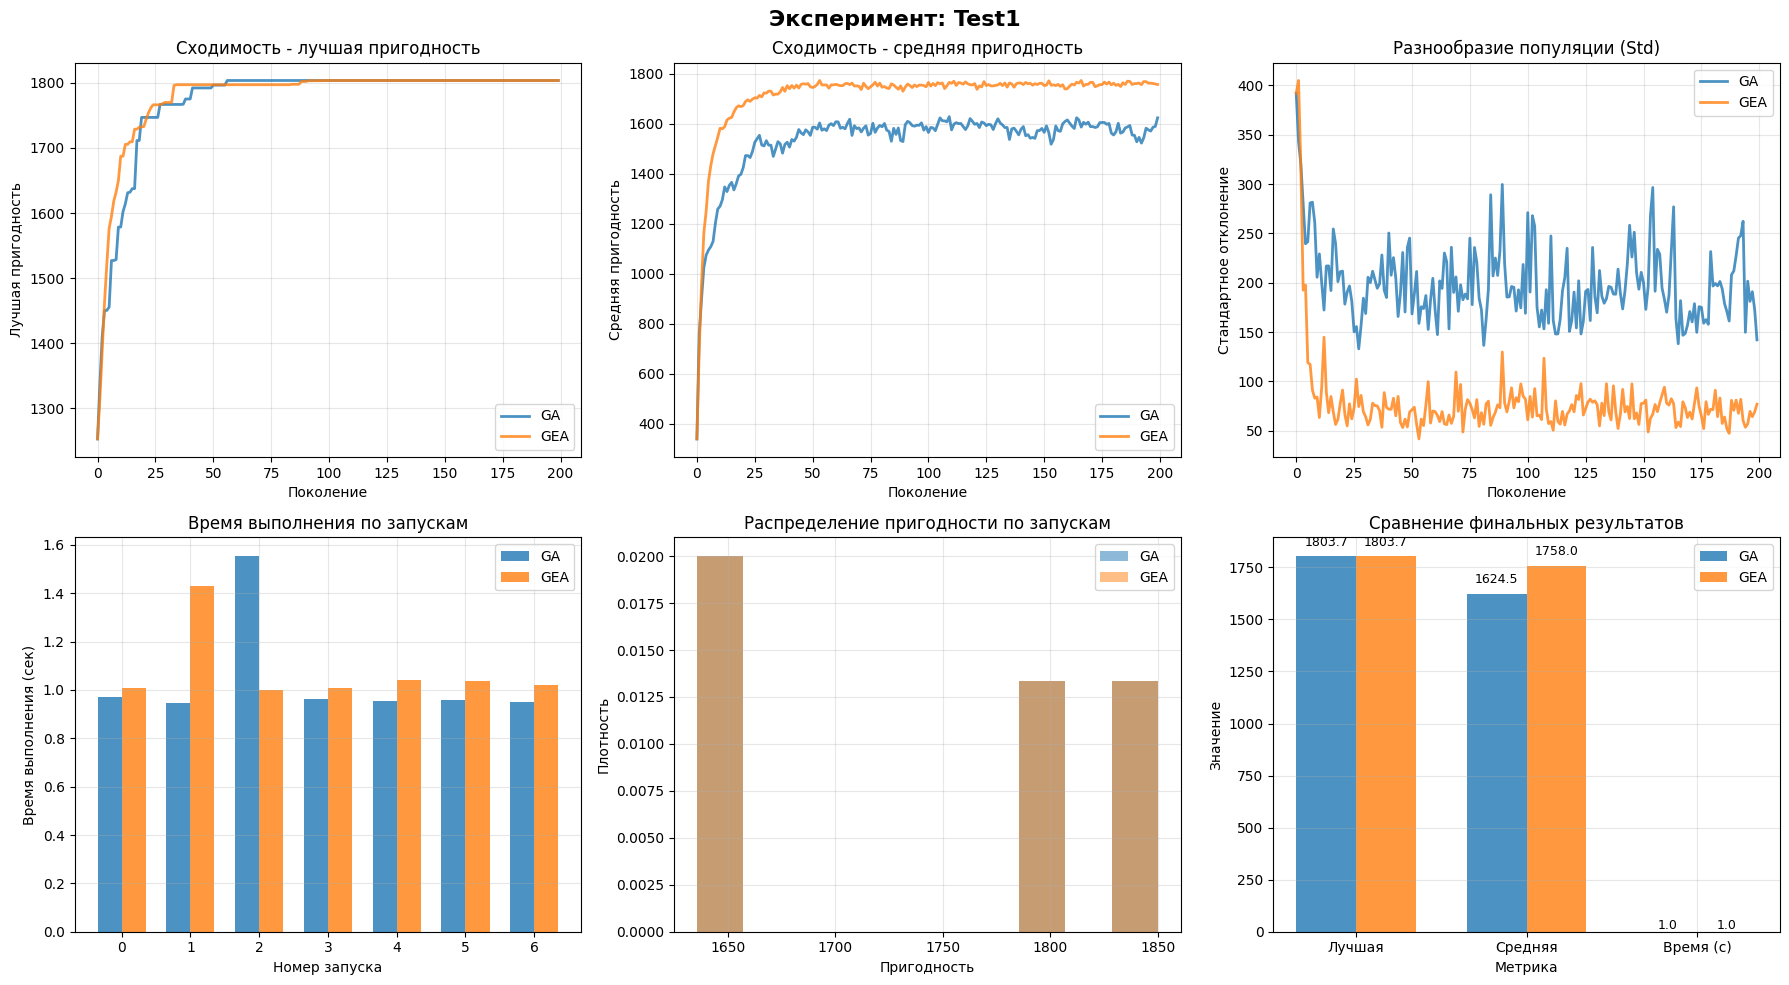


ЭКСПЕРИМЕНТ 2: Test2
Параметры: 100 предметов, вместимость 200

Результаты (7 запусков):
Метрика         GA                   GEA                 
--------------- -------------------- --------------------
Лучший          4233.50              4261.76             
Худший          3322.78              3349.59             
Средний         3789.77              3821.07             
Стд. откл.      284.18               287.25              
Время (с)       1.256                1.325               

Статистический анализ:
  Улучшение GEA: 0.83%
  t-статистика: 0.1897, p-value: 0.8527
  ВЫВОД: Нет статистически значимого различия (p ≥ 0.05)


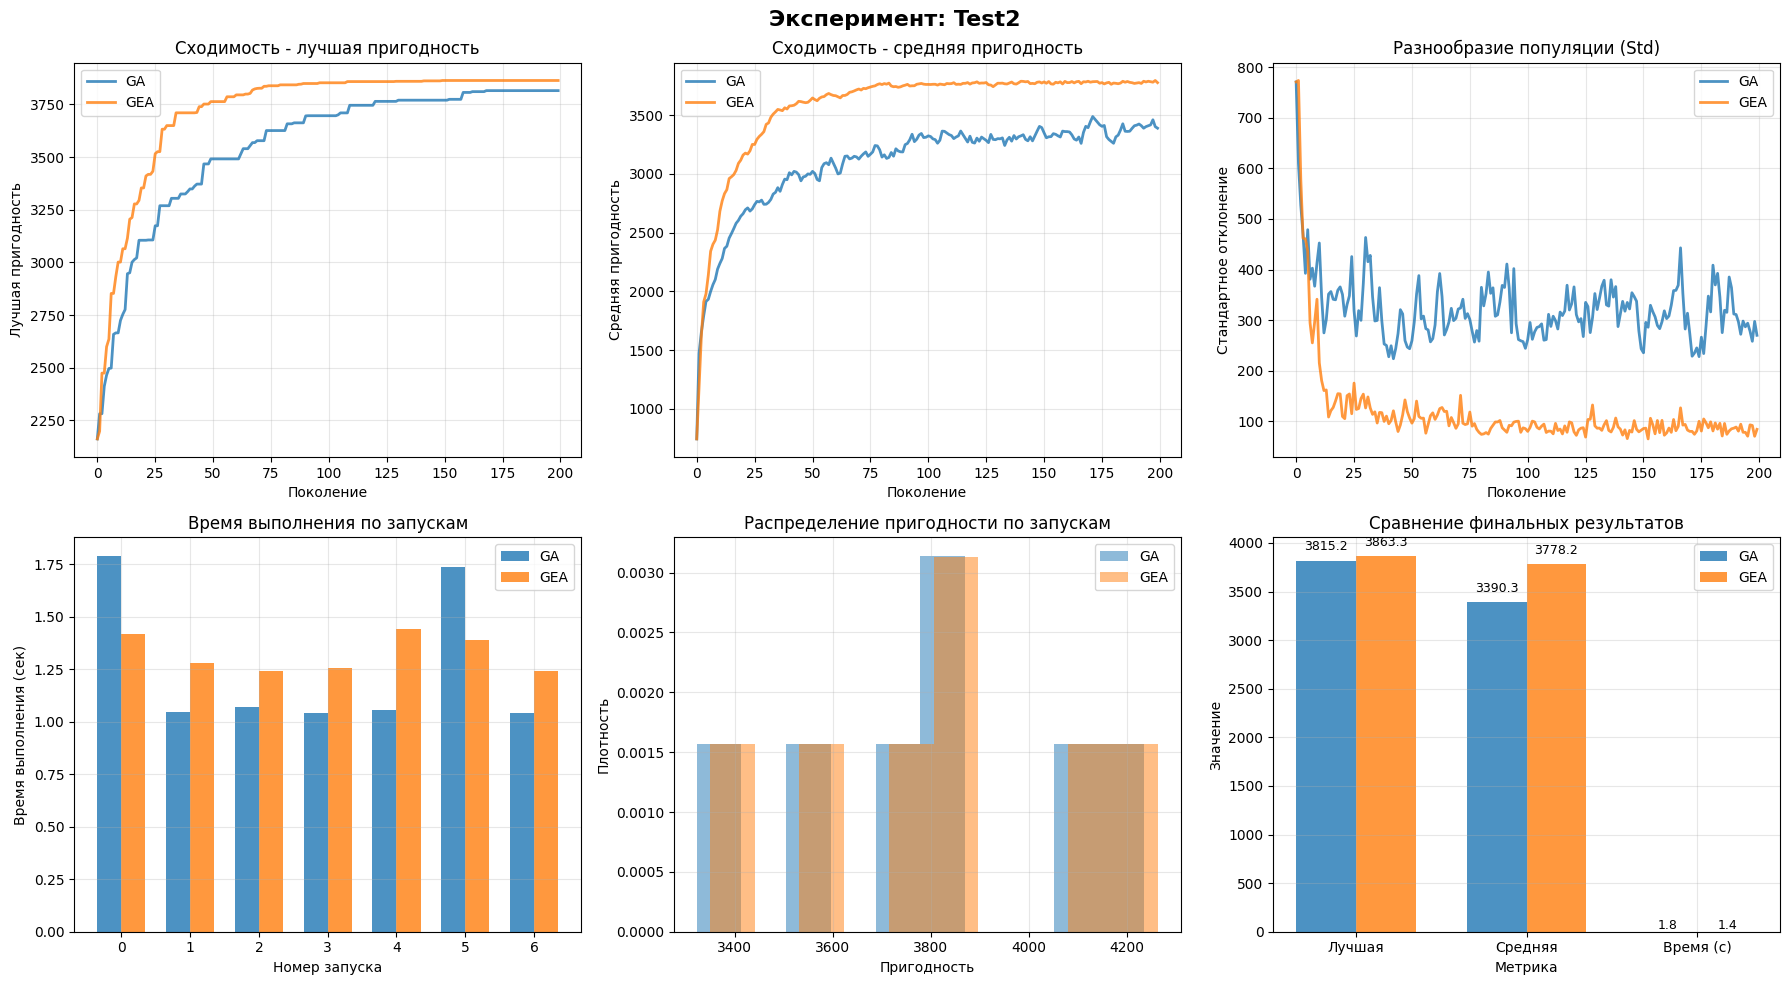


ЭКСПЕРИМЕНТ 3: Test3
Параметры: 150 предметов, вместимость 300

Результаты (7 запусков):
Метрика         GA                   GEA                 
--------------- -------------------- --------------------
Лучший          6678.48              6904.33             
Худший          5560.51              5693.32             
Средний         6074.88              6276.33             
Стд. откл.      407.58               442.39              
Время (с)       1.283                1.680               

Статистический анализ:
  Улучшение GEA: 3.32%
  t-статистика: 0.8203, p-value: 0.4280
  ВЫВОД: Нет статистически значимого различия (p ≥ 0.05)


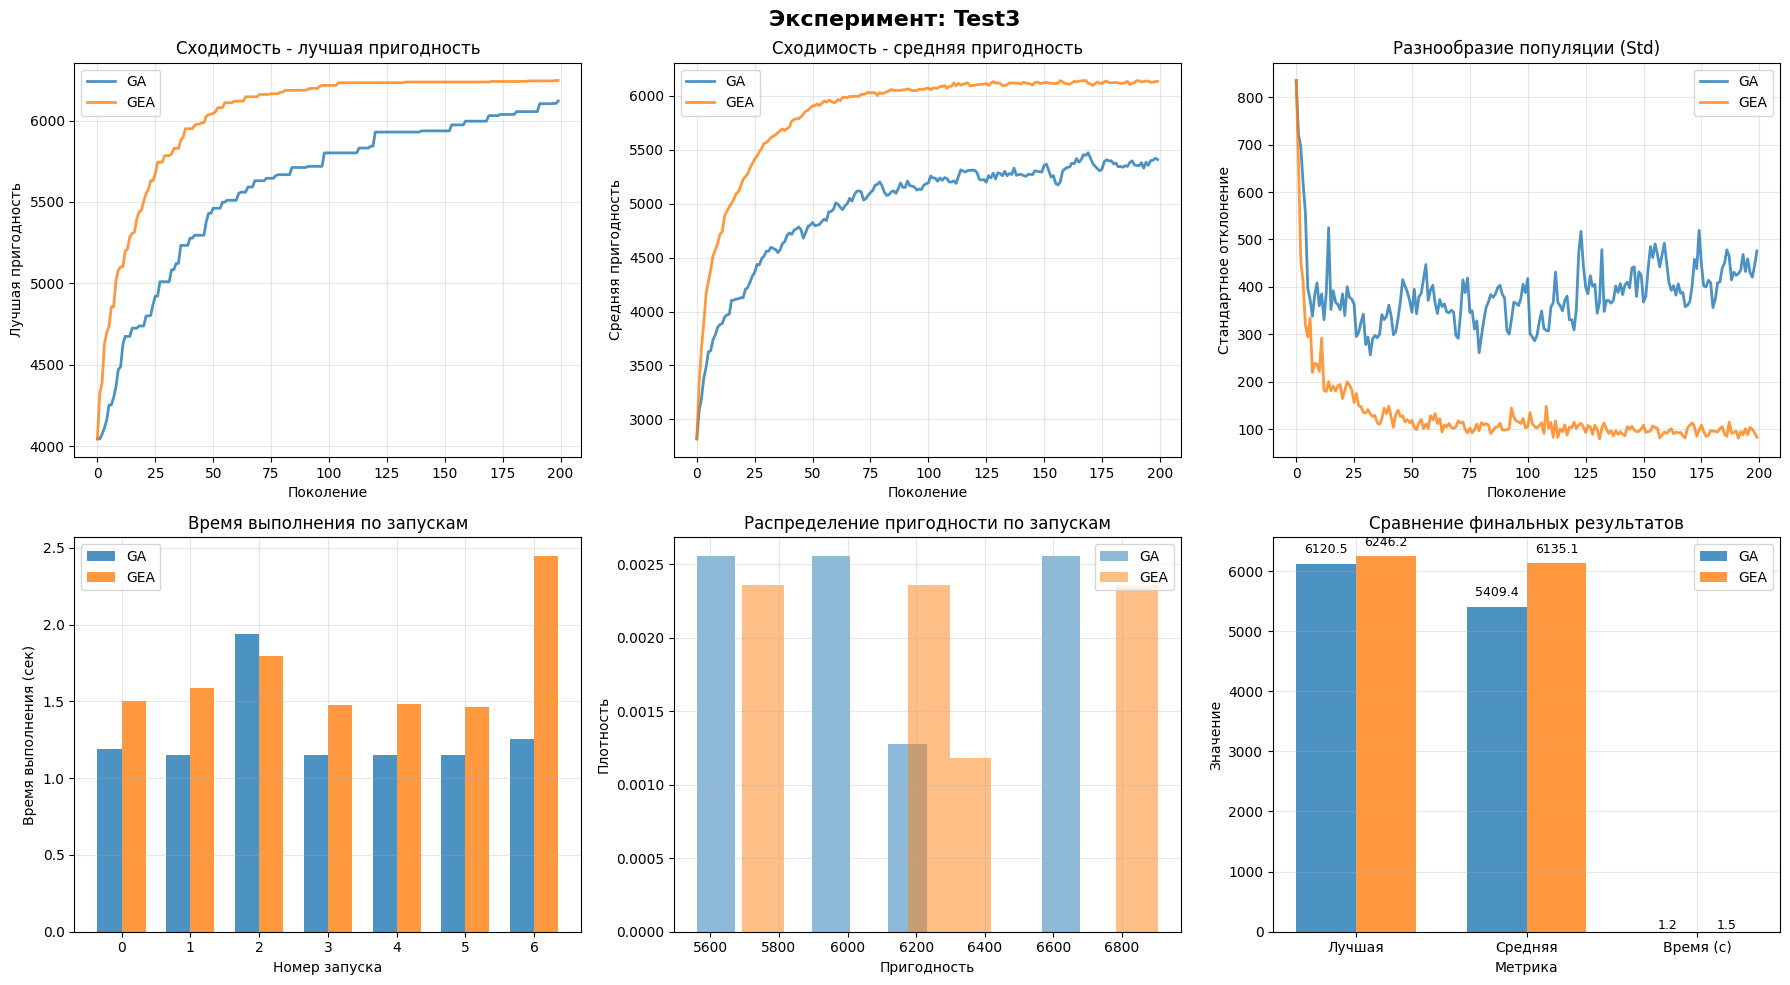


ЭКСПЕРИМЕНТ 4: Test4
Параметры: 200 предметов, вместимость 400

Результаты (7 запусков):
Метрика         GA                   GEA                 
--------------- -------------------- --------------------
Лучший          8658.10              9113.85             
Худший          7575.64              8028.30             
Средний         8125.72              8568.68             
Стд. откл.      295.01               300.56              
Время (с)       1.377                1.827               

Статистический анализ:
  Улучшение GEA: 5.45%
  t-статистика: 2.5763, p-value: 0.0243
  ВЫВОД: GEA статистически значимо лучше GA (p < 0.05)


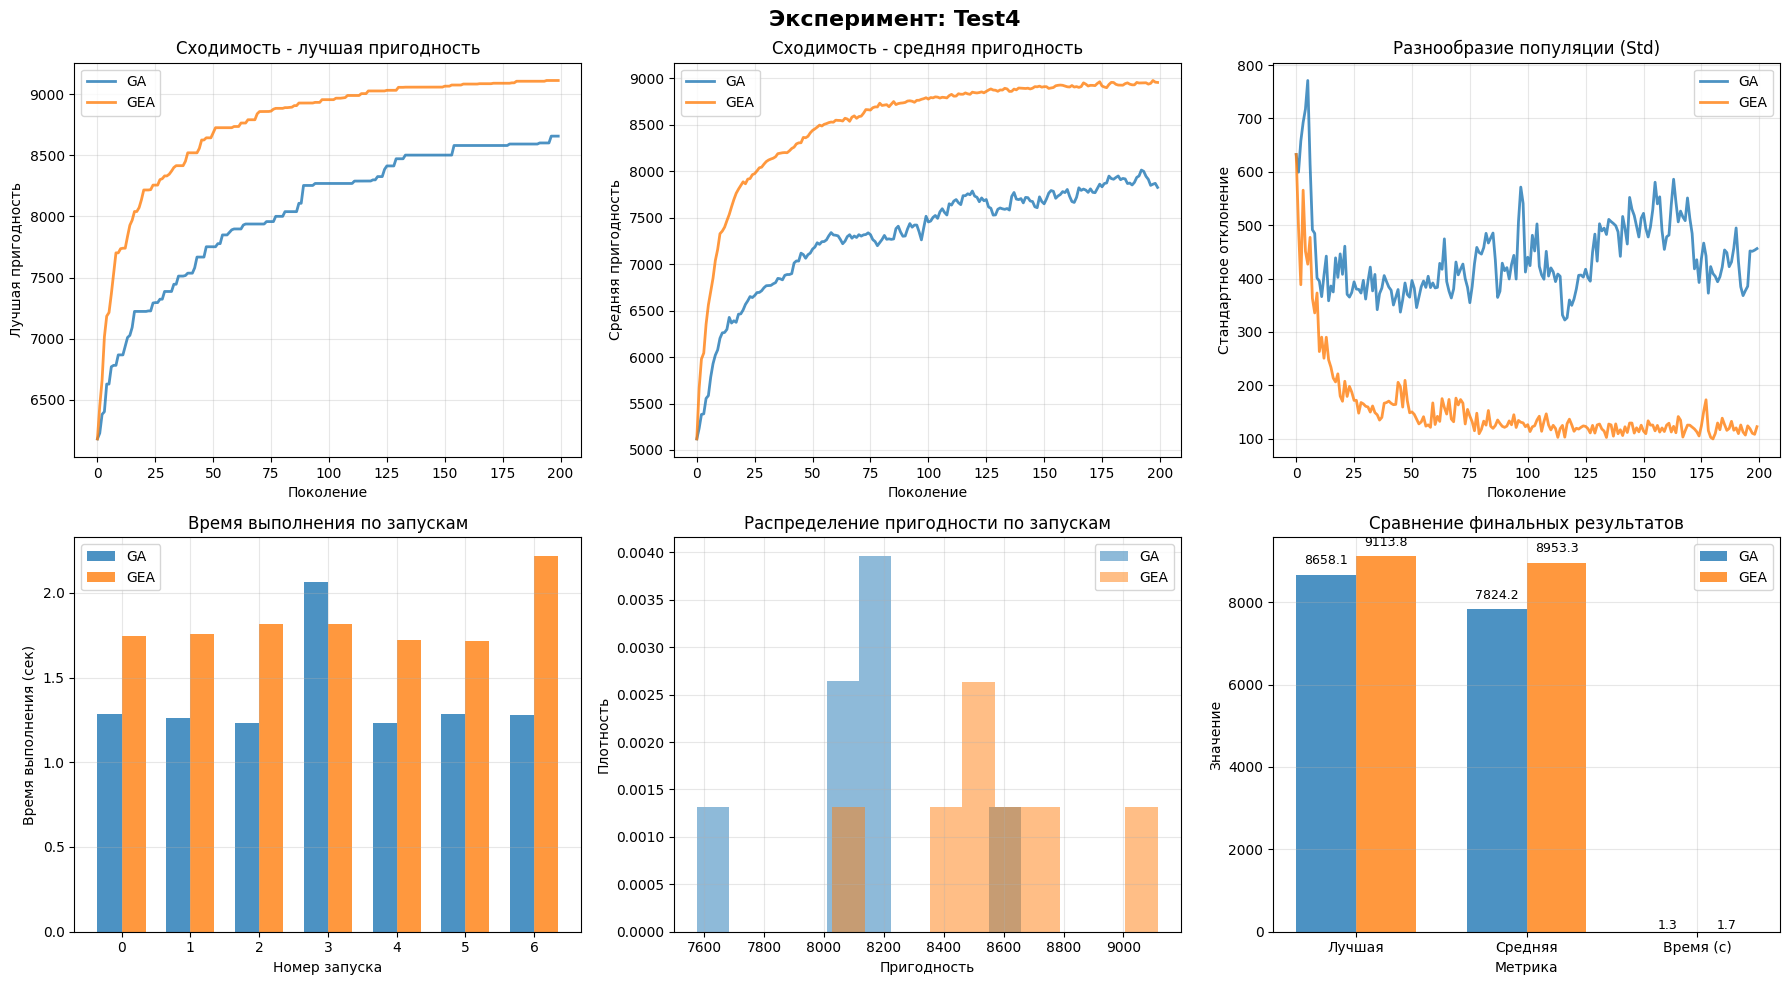


ЭКСПЕРИМЕНТ 5: Test5
Параметры: 250 предметов, вместимость 500

Результаты (7 запусков):
Метрика         GA                   GEA                 
--------------- -------------------- --------------------
Лучший          10620.23             11344.86            
Худший          9676.55              10424.80            
Средний         10114.35             10913.99            
Стд. откл.      350.38               353.00              
Время (с)       1.477                2.192               

Статистический анализ:
  Улучшение GEA: 7.91%
  t-статистика: 3.9381, p-value: 0.0020
  ВЫВОД: GEA статистически значимо лучше GA (p < 0.05)


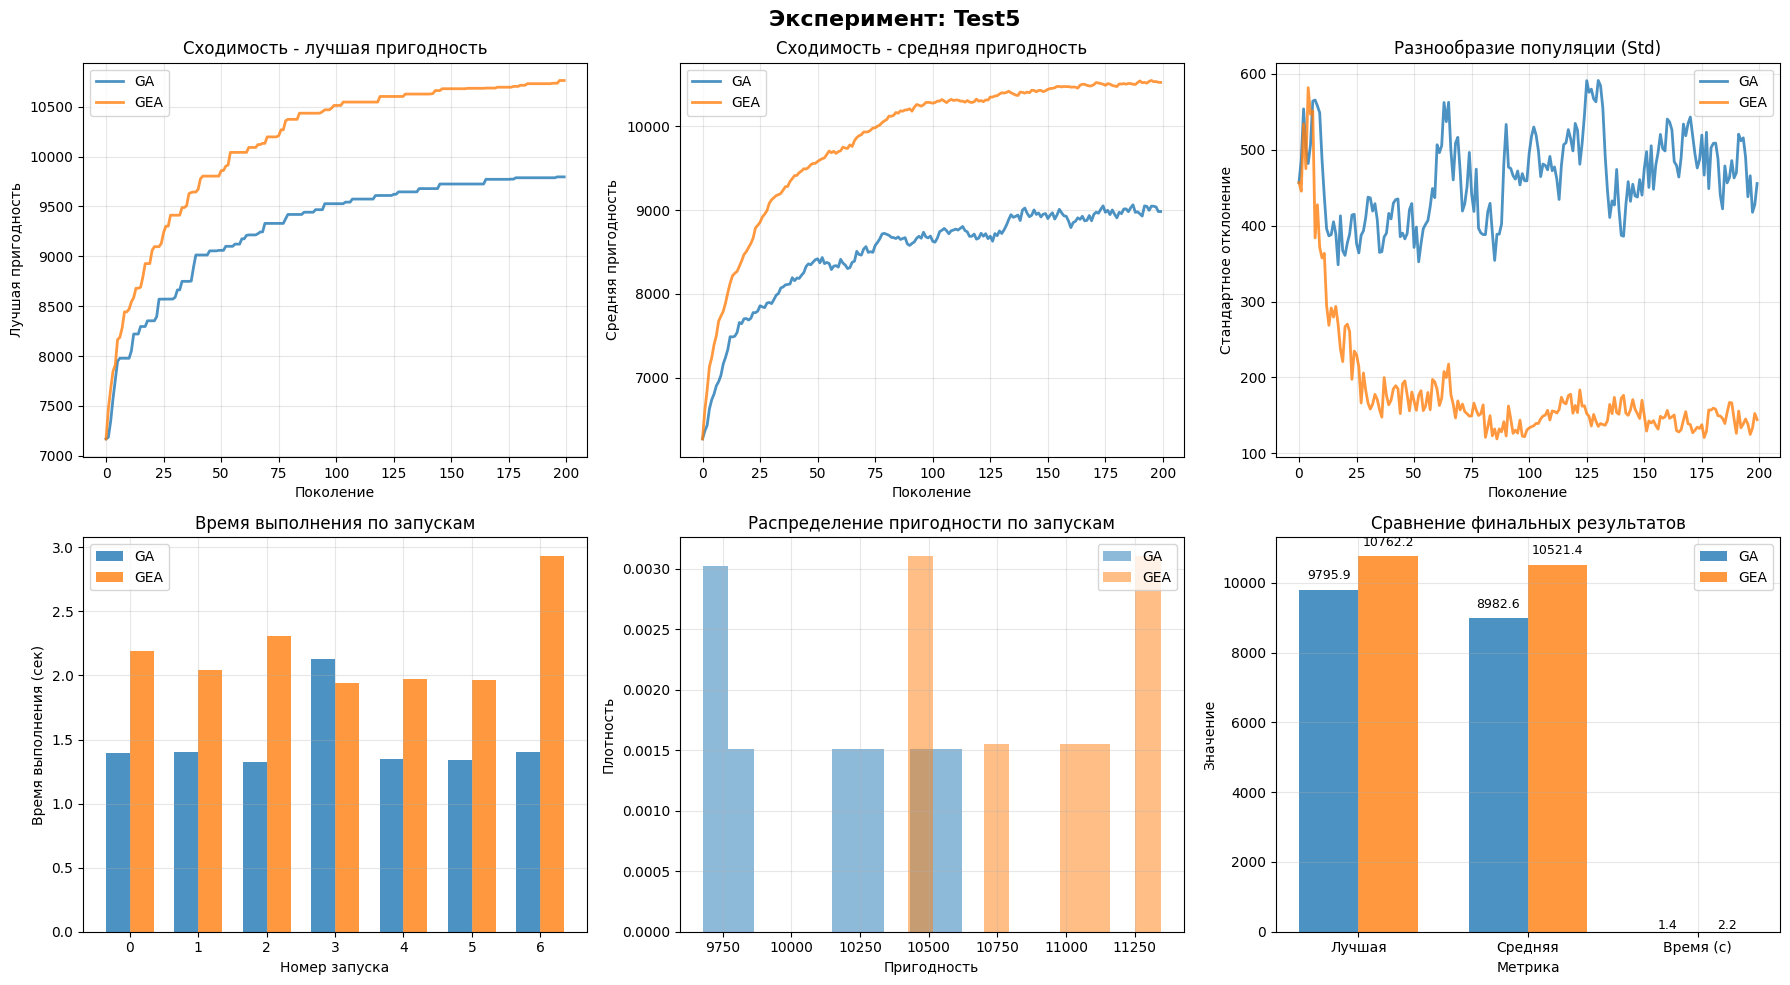


ЭКСПЕРИМЕНТ 6: Test6
Параметры: 300 предметов, вместимость 600

Результаты (7 запусков):
Метрика         GA                   GEA                 
--------------- -------------------- --------------------
Лучший          12797.69             14000.93            
Худший          11524.53             12397.97            
Средний         12059.41             13137.81            
Стд. откл.      434.92               524.81              
Время (с)       1.462                2.484               

Статистический анализ:
  Улучшение GEA: 8.94%
  t-статистика: 3.8754, p-value: 0.0022
  ВЫВОД: GEA статистически значимо лучше GA (p < 0.05)


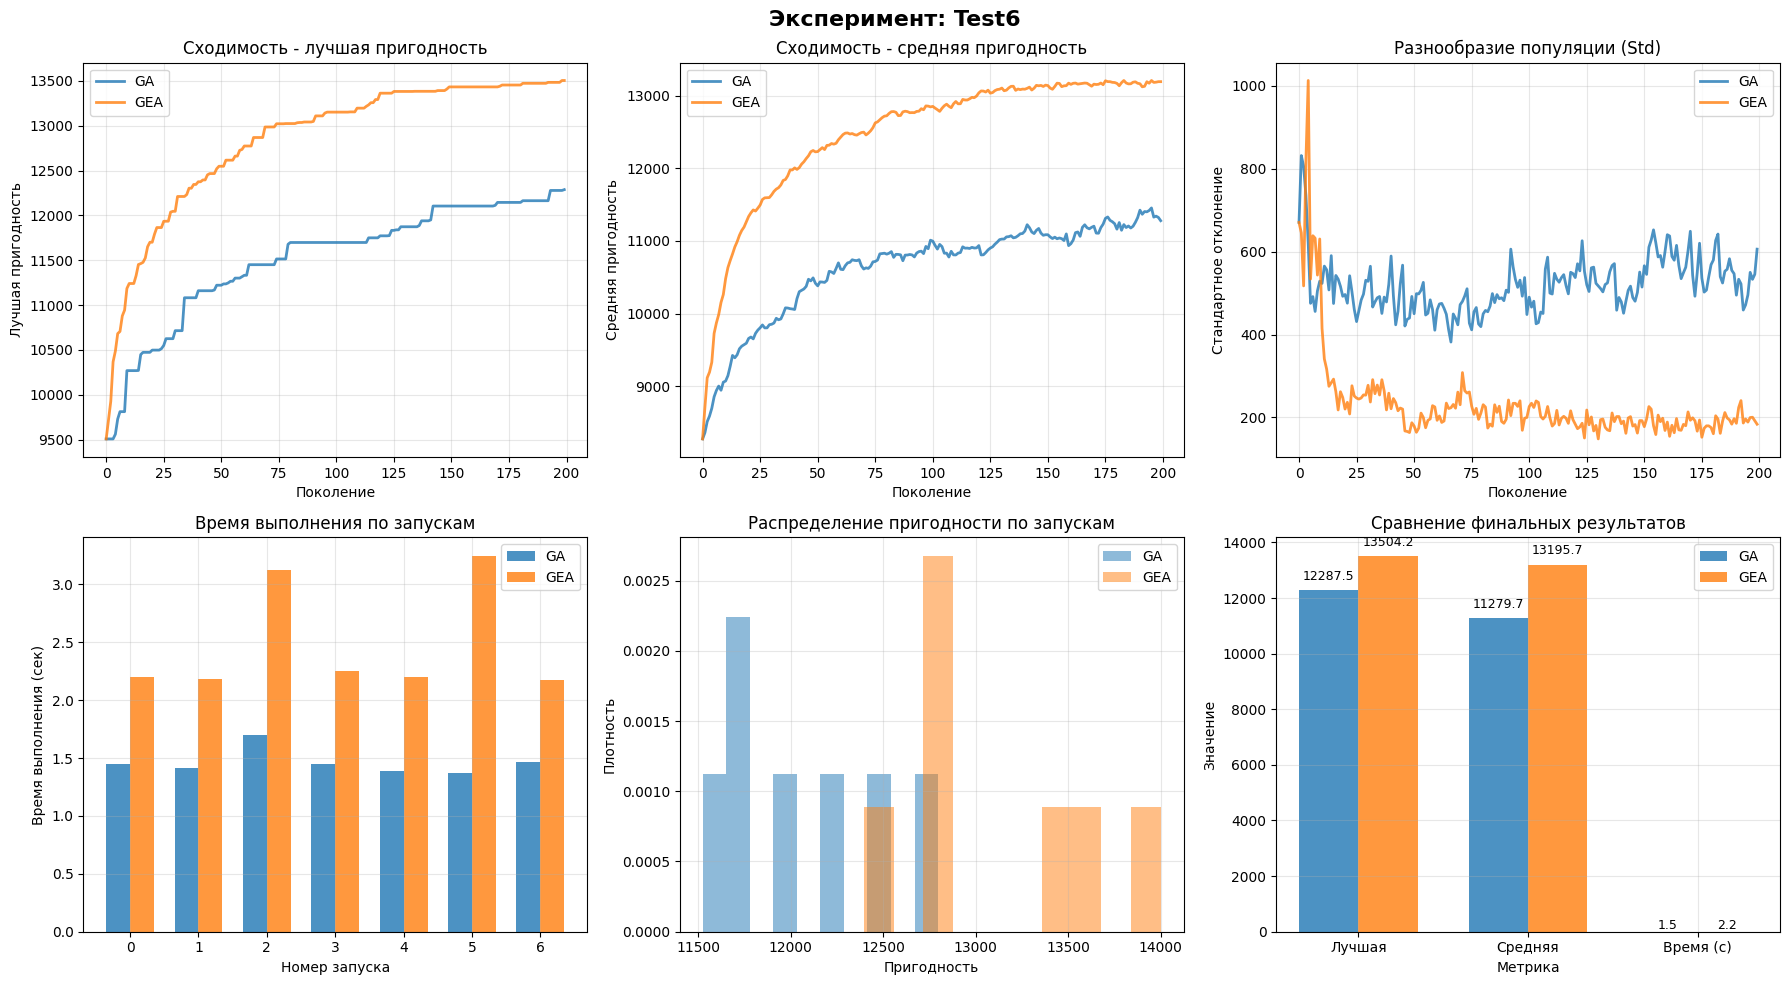


ФОРМИРОВАНИЕ ИТОГОВЫХ РЕЗУЛЬТАТОВ

ИТОГОВАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ

Таблица 1: Основные метрики по экспериментам
----------------------------------------------------------------------------------------------------
Test1    50       100        1743.08  1743.08  88.74    88.74    1.043    1.078   
Test2    100      200        3789.77  3821.07  284.18   287.25   1.256    1.325   
Test3    150      300        6074.88  6276.33  407.58   442.39   1.283    1.680   
Test4    200      400        8125.72  8568.68  295.01   300.56   1.377    1.827   
Test5    250      500        10114.35 10913.99 350.38   353.00   1.477    2.192   
Test6    300      600        12059.41 13137.81 434.92   524.81   1.462    2.484   
----------------------------------------------------------------------------------------------------
Average  175      350        6984.53  7410.16  310.13   332.79   1.316    1.764   


Таблица 2: Сравнение стандартных отклонений (стабильность)
---------------------------------------------

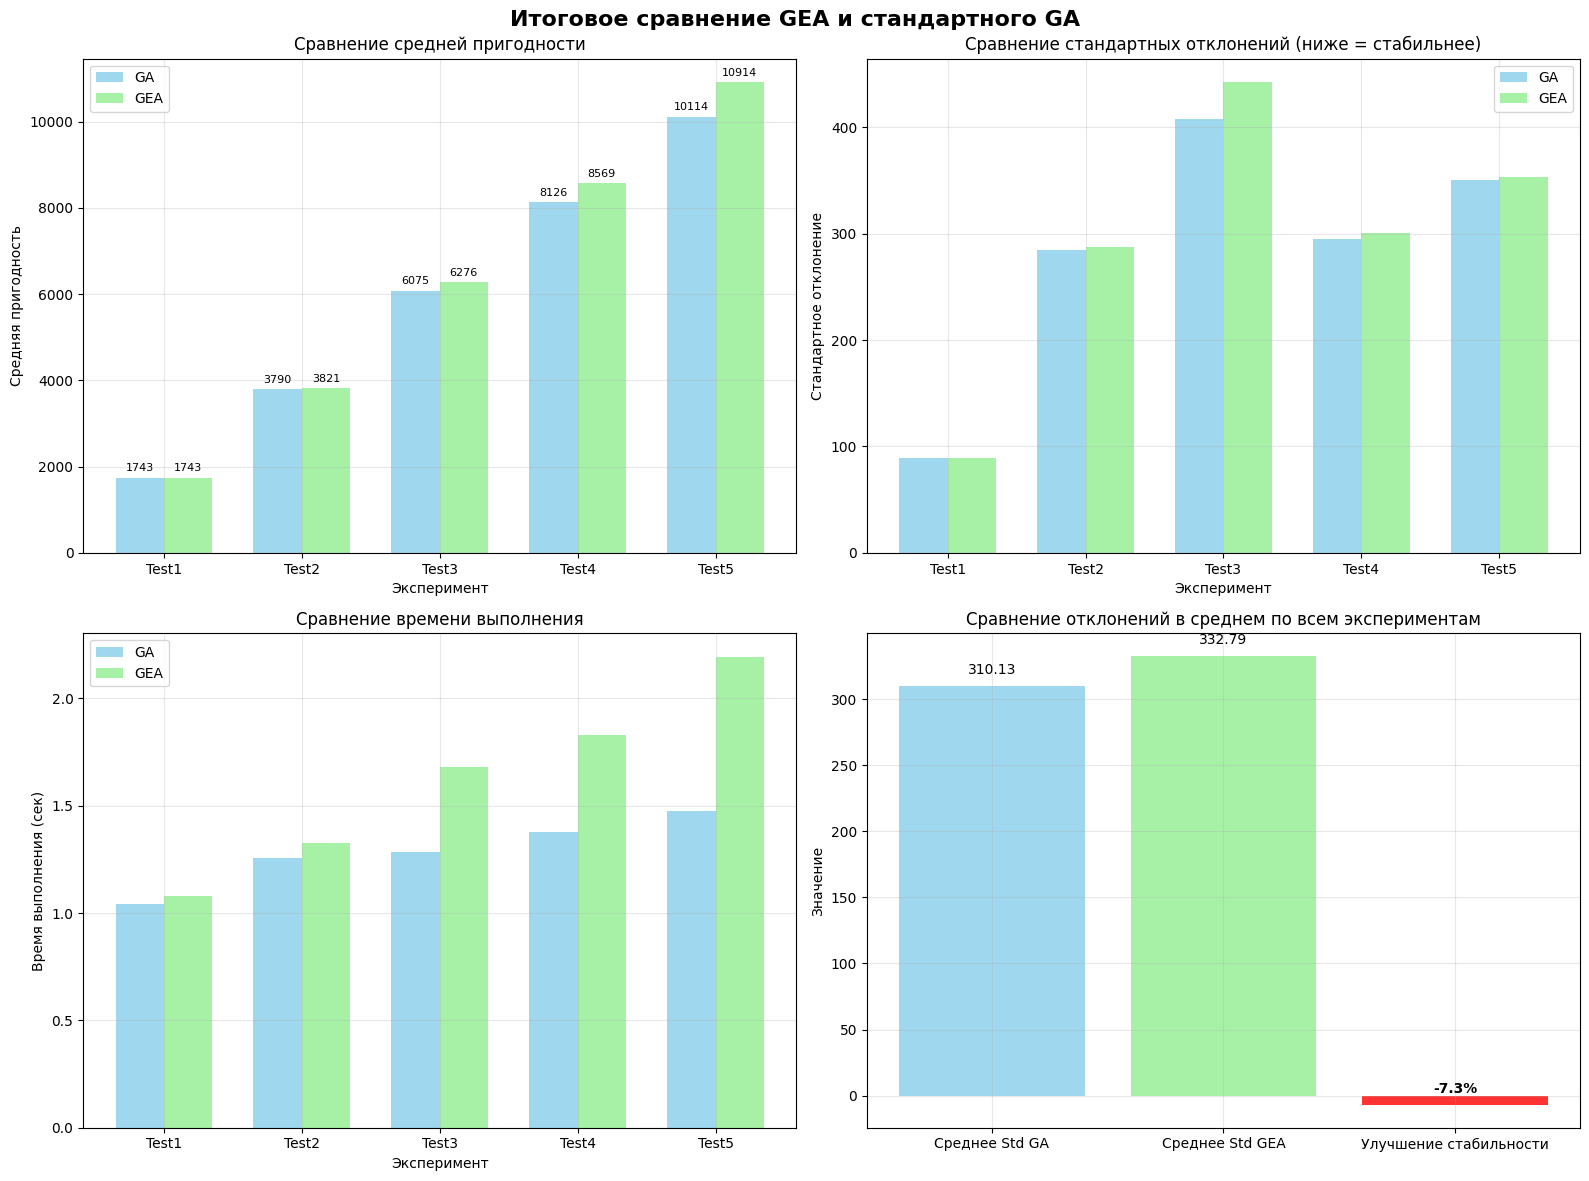

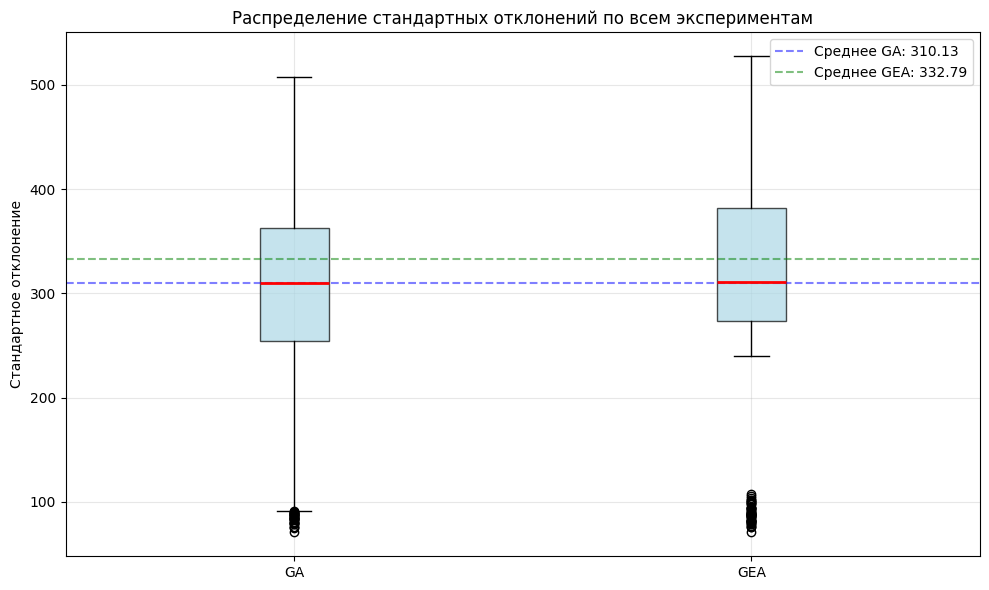


ОБЩИЕ ВЫВОДЫ И РЕКОМЕНДАЦИИ

1. КАЧЕСТВО РЕШЕНИЙ:
   • Среднее улучшение пригодности GEA: 4.4%
   • ВЫВОД: GEA дает лучшее качество решений

2. СТАБИЛЬНОСТЬ (Стандартные отклонения):
   • Среднее отклонение GA: 310.13
   • Среднее отклонение GEA: 332.79
   • Улучшение стабильности GEA: -7.3%
   • ВЫВОД: GA более стабилен (меньше отклонение)

3. ПРОИЗВОДИТЕЛЬНОСТЬ (Время выполнения):
   • Улучшение времени выполнения GEA: -31.8%
   • ВЫВОД: GA выполняется быстрее

4. ОБЩАЯ ОЦЕНКА:
   • GEA выиграл по критериям: 5 раз
   • GA выиграл по критериям: 13 раз
   • ФИНАЛЬНЫЙ ВЫВОД: Стандартный GA превосходит Genetic Engineering Algorithm (GEA)

5. РЕКОМЕНДАЦИИ:
   • Для простых задач можно использовать стандартный GA

ЭКСПЕРИМЕНТ ЗАВЕРШЕН


In [58]:

print("ЗАПУСК ПОЛНОГО ЭКСПЕРИМЕНТАЛЬНОГО АНАЛИЗА")
print("=" * 80)
print("Алгоритмы: Genetic Engineering Algorithm (GEA) vs Стандартный GA")
print("Задача: Оптимизация рюкзака (Knapsack Problem)")
print("=" * 80)

# Запуск экспериментов
summary_data, all_results = run_comprehensive_experiments()

# Создание итоговой таблицы
print("\n" + "=" * 100)
print("ФОРМИРОВАНИЕ ИТОГОВЫХ РЕЗУЛЬТАТОВ")
print("=" * 100)

summary_df, improvements, std_comparison = create_summary_table(summary_data)

# Построение итоговых графиков сравнения
print("\n" + "=" * 100)
print("ИТОГОВЫЕ ГРАФИКИ СРАВНЕНИЯ")
print("=" * 100)

plot_final_comparison(summary_df, std_comparison)

# Анализ и выводы
print("\n" + "=" * 100)
print("ОБЩИЕ ВЫВОДЫ И РЕКОМЕНДАЦИИ")
print("=" * 100)

# Извлечение средних значений улучшений
avg_fitness_improvement = np.mean([imp['Fitness_Improvement'] for imp in improvements])
avg_time_improvement = np.mean([imp['Time_Improvement'] for imp in improvements])
avg_std_improvement = np.mean([imp['Std_Improvement'] for imp in improvements])

avg_ga_std, avg_gea_std, overall_std_improvement = std_comparison

print(f"\n1. КАЧЕСТВО РЕШЕНИЙ:")
print(f"   • Среднее улучшение пригодности GEA: {avg_fitness_improvement:.1f}%")

if avg_fitness_improvement > 0:
    print(f"   • ВЫВОД: GEA дает лучшее качество решений")
else:
    print(f"   • ВЫВОД: GA дает лучшее качество решений")

print(f"\n2. СТАБИЛЬНОСТЬ (Стандартные отклонения):")
print(f"   • Среднее отклонение GA: {avg_ga_std:.2f}")
print(f"   • Среднее отклонение GEA: {avg_gea_std:.2f}")
print(f"   • Улучшение стабильности GEA: {overall_std_improvement:.1f}%")

if overall_std_improvement > 0:
    print(f"   • ВЫВОД: GEA более стабилен (меньше отклонение)")
else:
    print(f"   • ВЫВОД: GA более стабилен (меньше отклонение)")

print(f"\n3. ПРОИЗВОДИТЕЛЬНОСТЬ (Время выполнения):")
print(f"   • Улучшение времени выполнения GEA: {avg_time_improvement:.1f}%")

if avg_time_improvement > 0:
    print(f"   • ВЫВОД: GEA выполняется быстрее")
else:
    print(f"   • ВЫВОД: GA выполняется быстрее")

print(f"\n4. ОБЩАЯ ОЦЕНКА:")

# Подсчет "побед" каждого алгоритма
gea_wins = 0
ga_wins = 0

for imp in improvements:
    if imp['Fitness_Improvement'] > 0:
        gea_wins += 1
    else:
        ga_wins += 1

    if imp['Std_Improvement'] > 0:
        gea_wins += 1
    else:
        ga_wins += 1

    if imp['Time_Improvement'] > 0:
        gea_wins += 1
    else:
        ga_wins += 1

print(f"   • GEA выиграл по критериям: {gea_wins} раз")
print(f"   • GA выиграл по критериям: {ga_wins} раз")

if gea_wins > ga_wins:
    print(f"   • ФИНАЛЬНЫЙ ВЫВОД: Genetic Engineering Algorithm (GEA) превосходит стандартный GA")
elif ga_wins > gea_wins:
    print(f"   • ФИНАЛЬНЫЙ ВЫВОД: Стандартный GA превосходит Genetic Engineering Algorithm (GEA)")
else:
    print(f"   • ФИНАЛЬНЫЙ ВЫВОД: Алгоритмы показывают схожие результаты")

print(f"\n5. РЕКОМЕНДАЦИИ:")
if avg_fitness_improvement > 5 and overall_std_improvement > 10:
    print(f"   • РЕКОМЕНДУЕТСЯ использовать GEA для серьезных задач оптимизации")
elif avg_fitness_improvement > 0 and avg_time_improvement > 0:
    print(f"   • GEA рекомендуется для задач, где важны и качество, и скорость")
else:
    print(f"   • Для простых задач можно использовать стандартный GA")

print("\n" + "=" * 100)
print("ЭКСПЕРИМЕНТ ЗАВЕРШЕН")
print("=" * 100)